# Datenauswertung Versuch Kennlinien

In diesem Notebook werden Messdaten vom Moku:Go eingelesen, in einem Diagramm gezeichnet und weiter verarbeitet. 
Dieses Notebook beinahltet nicht die komplette Versucheauswertung und dient nur als Startpunkt.

Folgende Bibliotheken werden benötigt:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# MatplotLib Einstellungen:
plt.style.use('default') # Matplotlib Style wählen
plt.rcParams['font.size'] = 12; # Schriftgröße einstellen

## Daten einlesen, zuschneiden und plotten

Auswahl der Messdatei mit den Namen `MokuOscilloscopeData_20221007_133233_Traces.csv`, welche in `data_file` gespeichert wird. Die Messdatei kann aus dem [GitHub Repository](https://github.com/Kisleif/mtbook/blob/36a7260056dc5ba83466250d266b013e478f9df4/content/data/MokuOscilloscopeData_20221007_133233_Traces.csv) heruntergeladen werden. 

In [2]:
data_file = 'data/MokuOscilloscopeData_20221007_133233_Traces.csv'

Als nächstes werden die Messdaten aus der Datei `data_file` als Panda-Dataframe in der Variablen `data1` gespeichert. Da die Messdaten in der .csv-Datei mit Kommas getrennt sind, setzen wir als *Separator* `sep=','`. Die ersten 10 Zeilen sind in der .csv-Datei sind Kopfzeilen und beinhalten Metadaten. Sie werden beim Einlesen der Messdaten übersprungen mittels `header = 10`. Danach geben wir den drei einzelnen Spalten entsprechende Namen. 

In [3]:
data1 = pd.read_csv(data_file, sep = ',', header = 10, names = ['time_sec', 'Ch1_Volt', 'Ch2_Volt']) 

Wir tragen die beiden Messkanäle des Moku:Gos über die Zeit in einem Diagramm auf:

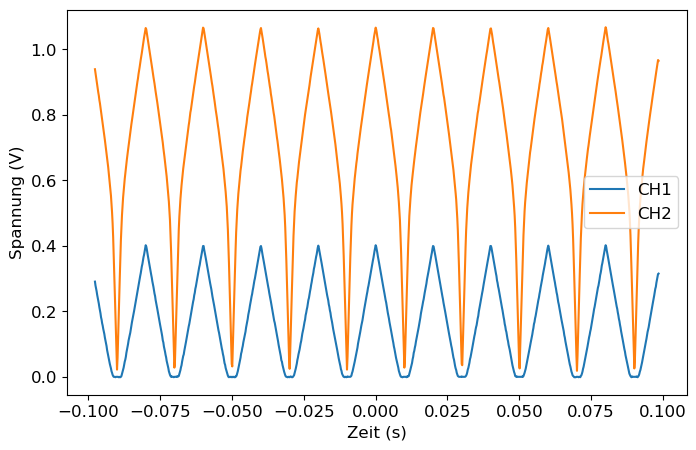

In [4]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.plot(data1['time_sec'], data1['Ch1_Volt'], label = 'CH1')
plt.plot(data1['time_sec'], data1['Ch2_Volt'], label = 'CH2')
plt.xlabel('Zeit (s)')
plt.ylabel('Spannung (V)')
plt.legend()
plt.show()

Wir sehen die angelegt Dreiecks-Spannung aus dem Versuchaufbau und schneiden die Messdaten für die weitere Verarbeitung entsprechend zu. Ziel ist es, die beiden Kanäle synchron auf eine Rampe zuzuschneiden. Wir wählen hierfür manuell Sample-Punkte `start` und `stop` die ihr auf eure Messdaten anpassen müsst. Kontrolliert zwischendurch immer das Diagramm.

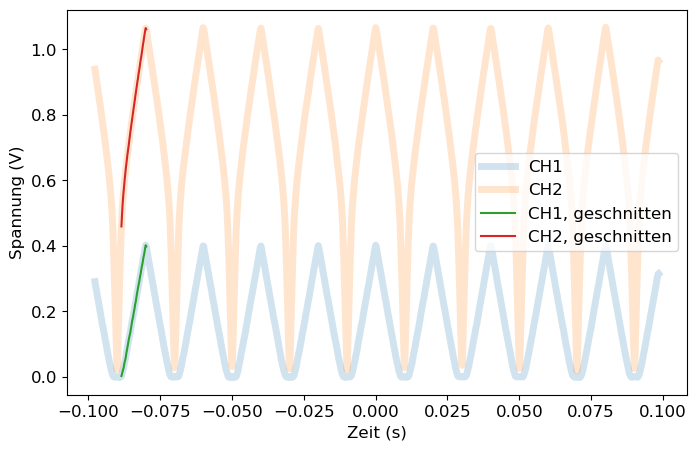

In [5]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
start = 48
stop = start + 46
plt.plot(data1['time_sec'], data1['Ch1_Volt'], lw = 5, alpha = 0.2, label = 'CH1')
plt.plot(data1['time_sec'], data1['Ch2_Volt'], lw = 5, alpha = 0.2, label = 'CH2')
plt.plot(data1['time_sec'][start:stop], data1['Ch1_Volt'][start:stop], label = 'CH1, geschnitten')
plt.plot(data1['time_sec'][start:stop], data1['Ch2_Volt'][start:stop], label = 'CH2, geschnitten')
plt.xlabel('Zeit (s)')
plt.ylabel('Spannung (V)')
plt.legend()
plt.show()

Sobald die Messdatenreihe so ausgewählt wurde, dass die Messdaten ausschließlich auf einer steigenden oder fallenden Flanke liegen (wie im obigen Beispiel) ist der richtige Bereich ausgewählt und wir speichern diesen Zeitabschnitt in einem neuen Datenset ab, indem wir `data1` mit dem Befehl `iloc[start:end]` zerschneiden. 
Die zugeschnittenen und konvertierten Messdaten speichern wir im Dataframe `data1_cut`.

In [6]:
data1_cut = {}
data1_cut['time_sec'] = data1['time_sec'].iloc[start:stop].dropna()
data1_cut['Ch1_Volt'] = data1['Ch1_Volt'].iloc[start:stop].dropna()
data1_cut['Ch2_Volt'] = data1['Ch2_Volt'].iloc[start:stop].dropna()

Kontrolliere die Daten indem du `data1_cut` erneut zeichnest:

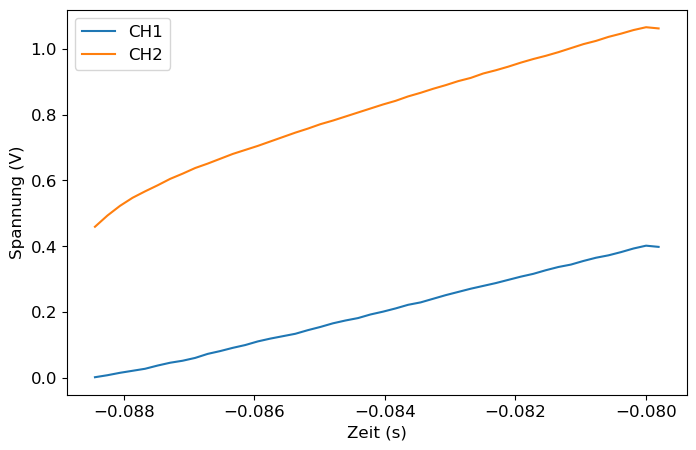

In [7]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.plot(data1_cut['time_sec'], data1_cut['Ch1_Volt'], label = 'CH1')
plt.plot(data1_cut['time_sec'], data1_cut['Ch2_Volt'], label = 'CH2')
plt.xlabel('Zeit (s)')
plt.ylabel('Spannung (V)')
plt.legend()
plt.show()

Solltet ihr im obigen Diagramm doch noch Umkehrpunkte sehen, müsst ihr die Grenzen `start`und `stop` weiter oben noch einmal erneut anpassen. 

## Messdaten skalieren und UI-Kennline zeichnen

Nun konvertieren die Messdaten gemäß der Versuchsanleitung in die richtigen Größen um:

$$I_{\mathrm{diode}} = \frac{U_\mathrm{ch1}}{R_{2}} = \frac{U_\mathrm{R_{2}}}{R_{2}}$$

$$U_\mathrm{diode} = U_\mathrm{ch2} - U_\mathrm{R_{2}} = U_\mathrm{ch2}  - U_\mathrm{ch1}$$

(Kontrolliert unbedingt ob ihr wirklich $R_2 = 100 \Omega$ eingebaut hattet! Ansonten müsst ihr den Wert hier entsprechend ändern.)

In [8]:
R2 = 100
data1_cut['I_diode'] = data1_cut['Ch1_Volt']/R2
data1_cut['U_diode'] = data1_cut['Ch2_Volt'] - data1_cut['Ch1_Volt']

Zeichnen der UI-Kennlinie mittels `Scatter`-Plot, um einzelne Messdatenpunkte darzustellen.

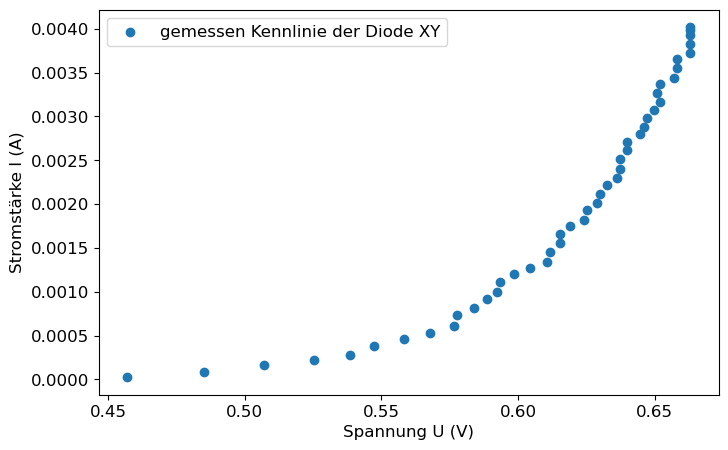

In [9]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.scatter(data1_cut['U_diode'], data1_cut['I_diode'], label = 'gemessen Kennlinie der Diode XY')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

## Funktion für die Ideale Kennlinie

Die Messdaten sollen nun mit der Modellfunktion der idealen Kennlinie gemäß dem Anleitungsskript gezeichnet werden:

$$I(U) = I_{R}(U) + I_{G} = I_{R}(U) - I_{R}(0) = I_{R}(0)\cdot \exp\left(\frac{eU}{k_{B}T}-1  \right)$$

Hierfür definieren wir zunächst die Funktion in Python, $I(U)$, mit den entsprechenden Naturkonstanten:

In [10]:
def I_U(U):
    T = 300 # als Temperatur wählen wir 300K, was in etwa Raumtemperatur entspricht. 
    k = 1.3e-23 # Boltzmann-Konstante in J/K
    e = 1.602e-19 # Elementarladung in C
    I_0 = 1.2e-14 # Stromstärke bei U = 0V
    return I_0 * np.exp(e*U/(k*T) -1)

Messdaten und Funktion werden in einem Diagramm gezeichnet. Um die Funktion darzustellen nutzen wir die gemessenen Spannungsdaten als x-Achse. Alternativ hätten wir auch ein neues Array erstellen können. 

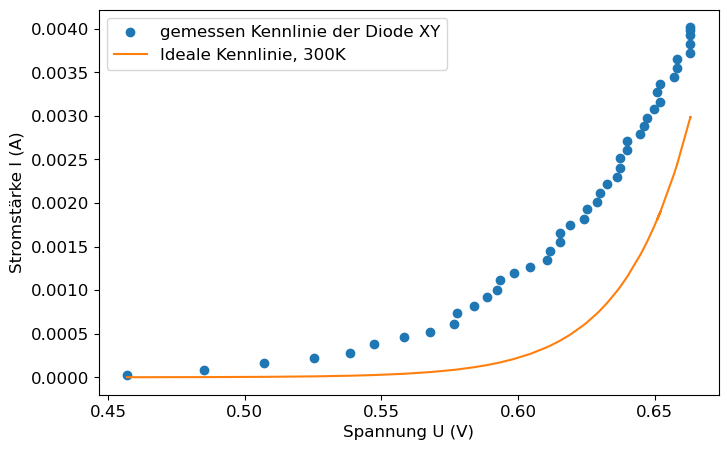

In [11]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.scatter(data1_cut['U_diode'], data1_cut['I_diode'], label = 'gemessen Kennlinie der Diode XY')
plt.plot(data1_cut['U_diode'], I_U(data1_cut['U_diode']), label = 'Ideale Kennlinie, 300K', color = 'tab:orange')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

Das gleiche zeichnen wir nun auf einer lagorithmischen Y-Achse:

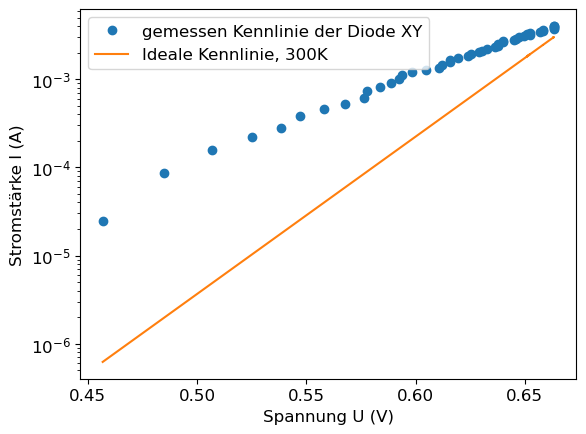

In [12]:
plt.semilogy(data1_cut['U_diode'],data1_cut['I_diode'], 'o', label = 'gemessen Kennlinie der Diode XY')
plt.semilogy(data1_cut['U_diode'], I_U(data1_cut['U_diode']), label = 'Ideale Kennlinie, 300K', color = 'tab:orange')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

## Funktion an Messdaten anpassen

Zum fitten benutzen wir die `curve_fit` Funktion von `scipy`.

In [13]:
from scipy.optimize import curve_fit

Wir fitten in logerithmischen Einheiten auf der Y-Achse und rechnen daher die Stromstärke in die Einheit dB um und speichern sie in der Variablen `y`. Die Spannungsdaten bleiben unverändert, werden nur in `x` abgespeichert.

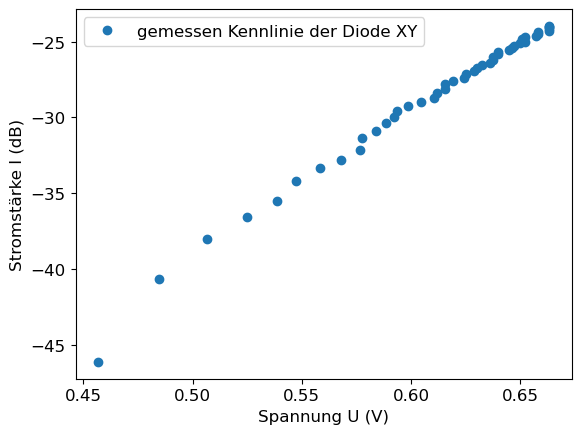

In [14]:
x = data1_cut['U_diode'].dropna()
y = 10*np.log10(data1_cut['I_diode'].dropna())

plt.plot(x,y, 'o', label = 'gemessen Kennlinie der Diode XY')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (dB)')
plt.legend()
plt.show()

Das Diagramm zeigt eine identische Repräsentation der Messdaten wie im vorangegangenen Abschnitt mit der logarithmischen Y-Achse. Nun wurden jedoch die Y-Messwerte anstelle der Achse umgerechnet und wir können die Messdaten mit einer einfachen linearen Regression anpassen (ansonsten hätten wir eine exponentielle Fit-Funktion benötigt). Zunächst definieren wie hierfür die lineare Funktion

$$y = ax + b$$

In [15]:
def fit_func(x, a, b):
    return a * x + b

Dann fitten wir die Funktion an die Messdaten an:

In [16]:
popt, pcov = curve_fit(fit_func, x , y)

Anschließend zeichnen wir das Ergebnis gemeinsam mit den Messwerten in ein Diagramm und geben uns das Fit-Ergebnis aus:

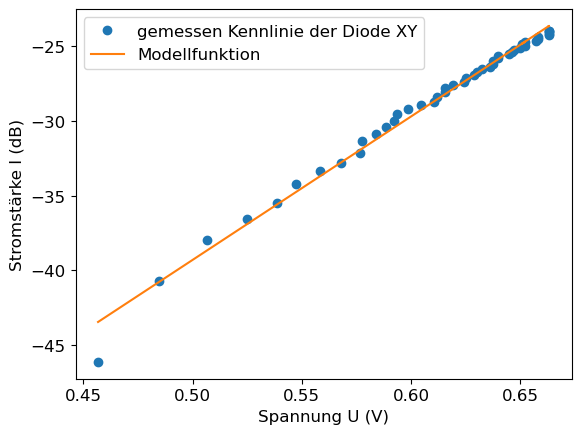

Y-Achsenabschnitt für y = U = 0 ist:  -87.263994734694 dB =  1.8775889752721304e-09 A


In [17]:
plt.plot(x,y, 'o', label = 'gemessen Kennlinie der Diode XY')
plt.plot(x,fit_func(x,*popt), label = 'Modellfunktion')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (dB)')
plt.legend()
plt.show()

print('Y-Achsenabschnitt für y = U = 0 ist: ', popt[1], 'dB = ',  10**(popt[1]/10), 'A')

Der Parameter `popt` beinhaltet die Werte für $a,b$ der Fit-Funktion und `pcov` die Kovarianzmatrix.

In [18]:
popt

array([ 95.92376083, -87.26399473])

In [19]:
pcov

array([[ 2.4548393 , -1.50165405],
       [-1.50165405,  0.92455696]])

# Bestimmung von h

Bestimmung von $h$ erfolgt in linearen Einheiten, da nur der "hintere" Teil der Messdaten (wenn die Diode durchlässig wird) gefittet werden soll. Als erstes werden die Messdaten entsprechend zugeschnitten, um eine lineare Regression nur in dem zu interessierenden Bereich ab einer bestimmten Spannung anzupassen. Als erstes guckt man sich die Original-Messdaten an und entschließt sich für eine unterege Grenze von Messdaten. 

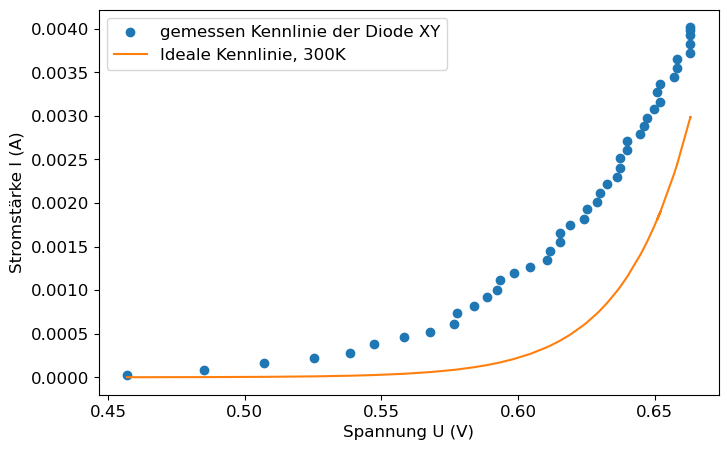

In [20]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.scatter(data1_cut['U_diode'], data1_cut['I_diode'], label = 'gemessen Kennlinie der Diode XY')
plt.plot(data1_cut['U_diode'], I_U(data1_cut['U_diode']), label = 'Ideale Kennlinie, 300K', color = 'tab:orange')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

Nun interessiert man sich lediglich für die Messdaten ab einer Spannung von etwa 0,6V. Mittels `.dropna` werden alle NaN-Werte (also Werte unterhalb der Grenze von 0,6V) aus dem DataFrame entfernt:

In [21]:
data1_cut = pd.DataFrame(data1_cut)
data1_cut["U_diode_fuer_h"]=data1_cut.loc[data1_cut["U_diode"] >= 0.6,"U_diode"]
data1_cut["I_diode_fuer_h"]=data1_cut.loc[data1_cut["U_diode"] >= 0.6,"I_diode"]
data1_cut = data1_cut.dropna()

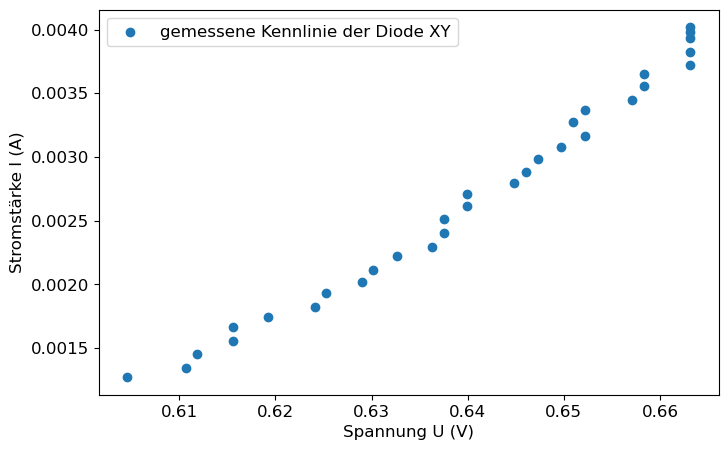

In [22]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.scatter(data1_cut['U_diode_fuer_h'], data1_cut['I_diode_fuer_h'], label = 'gemessene Kennlinie der Diode XY')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

In diesen hinteren Bereich der Kurve soll nun eine lineare Regression angepasst werden:

In [23]:
def fit_func(x, a, b):
    return a * x + b

popt, pcov = curve_fit(fit_func, data1_cut["U_diode_fuer_h"] , data1_cut["I_diode_fuer_h"])

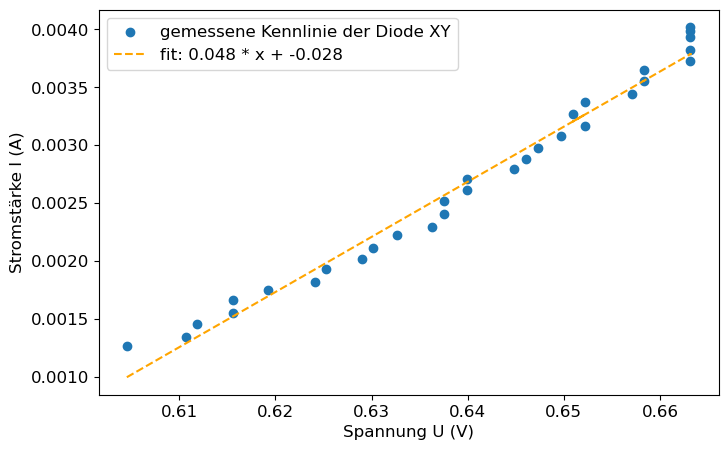

In [24]:
plt.figure(figsize=(8,5)) # Diagramm-Größe einstellen
plt.scatter(data1_cut['U_diode_fuer_h'], data1_cut['I_diode_fuer_h'], label = 'gemessene Kennlinie der Diode XY')
plt.plot(data1_cut["U_diode_fuer_h"], fit_func(data1_cut["U_diode_fuer_h"],*popt), label = 'fit: %5.3f * x + %5.3f' % tuple(popt), color = 'orange', ls='--')
plt.xlabel('Spannung U (V)')
plt.ylabel('Stromstärke I (A)')
plt.legend()
plt.show()

